In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

# Import EEC databases

In [3]:
df_21_1 = pd.read_parquet(r'..\Data\EEC_2021\t211z.parquet')
df_21_2 = pd.read_parquet(r'..\Data\EEC_2021\t212z.parquet')
df_21_3 = pd.read_parquet(r'..\Data\EEC_2021\t213z.parquet')
df_21_4 = pd.read_parquet(r'..\Data\EEC_2021\t214z.parquet')

df_22_1 = pd.read_parquet(r'..\Data\EEC_2022\t221z.parquet')
df_22_2 = pd.read_parquet(r'..\Data\EEC_2022\t222z.parquet')
df_22_3 = pd.read_parquet(r'..\Data\EEC_2022\t223z.parquet')
df_22_4 = pd.read_parquet(r'..\Data\EEC_2022\t224z.parquet')

df_23_1 = pd.read_parquet(r'..\Data\EEC_2023\t231z.parquet')
df_23_2 = pd.read_parquet(r'..\Data\EEC_2023\t232z.parquet')
df_23_3 = pd.read_parquet(r'..\Data\EEC_2023\t233z.parquet')
df_23_4 = pd.read_parquet(r'..\Data\EEC_2023\t234z.parquet')


In [4]:
dataframes = [df_21_1, df_21_2, df_21_3, df_21_4, df_22_1, df_22_2, df_22_3, df_22_4, df_23_1,df_23_1, df_23_1 , df_23_1]
all_data = pd.concat(dataframes, ignore_index = True)

# Data preprocessing

In [5]:
df_entrant = all_data[all_data['RGA']=='1'][['TELETRAV_Y', 'SALMEE_Y', 'SALMET_Y', 'SEXE', 'APCS_LIB', 'APCS1', 'APCS1Q', 'APCS2', 'APCS3','APCS4', 'DEPCOM', 'LIBETRF', 'AGEQ', 'AGE', 'DEPTRAV', 'LFS_HATLEVELLOW', 'NBENFLOG', 'NAFG010N']]

df_preproc = df_entrant[
    (df_entrant['TELETRAV_Y']!=9)
    &(df_entrant['SALMEE_Y']<20000)
    ].dropna(subset=['TELETRAV_Y'])

df_preproc[['TELETRAV_Y', 'AGEQ']] = df_preproc[['TELETRAV_Y', 'AGEQ']].astype(int)
df_preproc[['SALMEE_Y']] = df_preproc[['SALMEE_Y']].astype(float)

df_preproc['remote'] = df_preproc['TELETRAV_Y'].apply(lambda x:0 if x==2 else 1)
bins = [0, 1000, 2000, 3000, 4000, float('inf')]
labels = ['0-1000', '1000-2000', '2000-3000', '3000-4000', '4000+']
df_preproc['salary_bin'] = pd.cut(df_preproc['SALMEE_Y'], bins=bins, labels=labels, right=False)
df_preproc = pd.get_dummies(df_preproc, columns=['AGEQ', 'salary_bin', 'NAFG010N', 'APCS1Q', 'APCS1','LFS_HATLEVELLOW'], prefix=['AGEQ', 'SAL', 'SEC', 'APCS1Q', 'APCS1', 'EDU'], drop_first=False, dtype=int)
df_preproc['has_child'] = (df_preproc['NBENFLOG']>0).astype(int)

cols_50plus = [col for col in df_preproc.columns if col.startswith('AGEQ_') and int(col.split('_')[1])>=50]
df_preproc['AGEQ_50plus'] = df_preproc[cols_50plus].sum(axis=1).clip(upper=1)
df_preproc.drop(columns=cols_50plus, inplace=True)

print(f"Cleaned dataset shape : {df_preproc.shape}")

Cleaned dataset shape : (53649, 65)


In [6]:
df_remote = df_preproc[df_preproc['remote']==1]
df_no_remote = df_preproc[df_preproc['remote']==0]
print(f"Number of workers teleworking: {df_remote.shape[0]}")
print(f"Number of workers not teleworking : {df_no_remote.shape[0]}")

Number of workers teleworking: 10959
Number of workers not teleworking : 42690


# Gender preferences for teleworking

In [7]:
df_preproc.columns

Index(['TELETRAV_Y', 'SALMEE_Y', 'SALMET_Y', 'SEXE', 'APCS_LIB', 'APCS2',
       'APCS3', 'APCS4', 'DEPCOM', 'LIBETRF', 'AGE', 'DEPTRAV', 'NBENFLOG',
       'remote', 'AGEQ_15', 'AGEQ_20', 'AGEQ_25', 'AGEQ_30', 'AGEQ_35',
       'AGEQ_40', 'AGEQ_45', 'SAL_0-1000', 'SAL_1000-2000', 'SAL_2000-3000',
       'SAL_3000-4000', 'SAL_4000+', 'SEC_00', 'SEC_AZ', 'SEC_BE', 'SEC_FZ',
       'SEC_GI', 'SEC_JZ', 'SEC_KZ', 'SEC_LZ', 'SEC_MN', 'SEC_OQ', 'SEC_RU',
       'APCS1Q_00', 'APCS1Q_10', 'APCS1Q_20', 'APCS1Q_30', 'APCS1Q_40',
       'APCS1Q_51', 'APCS1Q_52', 'APCS1Q_61', 'APCS1Q_62', 'APCS1_0',
       'APCS1_1', 'APCS1_2', 'APCS1_3', 'APCS1_4', 'APCS1_5', 'APCS1_6',
       'EDU_0', 'EDU_1', 'EDU_2', 'EDU_3', 'EDU_4', 'EDU_5', 'EDU_6', 'EDU_7',
       'EDU_8', 'EDU_9', 'has_child', 'AGEQ_50plus'],
      dtype='object')

In [8]:
X = sm.add_constant(
    df_preproc[[            
      'SEXE', 
      'AGEQ_15',
      'AGEQ_20',
      'AGEQ_25', 
      'AGEQ_30',  # age between 30 and 35 is the reference category
      # 'AGEQ_35',
      'AGEQ_40', 
      'AGEQ_45', 
      'AGEQ_50plus', 
      'SAL_0-1000',
      'SAL_1000-2000', 
      # 'SAL_2000-3000', # salary between 2000 and 3000 is the reference category
      'SAL_3000-4000', 
      'SAL_4000+', 
      # 'SEC_AZ', # sector AZ is the reference sector
      'SEC_BE', 
      'SEC_FZ', 
      'SEC_GI', 
      'SEC_JZ',
      'SEC_KZ', 
      'SEC_LZ', 
      'SEC_MN', 
      'SEC_OQ', 
      'SEC_RU'
       ]].dropna())
X_encoded = pd.get_dummies(X, drop_first=True).astype(int)
y = df_preproc[['remote']]

## Probit model

In [9]:
model = sm.Probit(y,X_encoded)
result = model.fit()
print(result.summary())
result.get_margeff().summary()

Optimization terminated successfully.
         Current function value: 0.403514
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:                 remote   No. Observations:                53649
Model:                         Probit   Df Residuals:                    53627
Method:                           MLE   Df Model:                           21
Date:                Fri, 16 May 2025   Pseudo R-squ.:                  0.2030
Time:                        18:48:57   Log-Likelihood:                -21648.
converged:                       True   LL-Null:                       -27161.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.9671      0.068    -14.232      0.000      -1.100      -0.834
AGEQ_15          -0.

<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:                 remote
Method:                          dydx
At:                           overall
=================================================================================
                   dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
AGEQ_15          -0.1595      0.022     -7.317      0.000      -0.202      -0.117
AGEQ_20          -0.0209      0.008     -2.742      0.006      -0.036      -0.006
AGEQ_25           0.0089      0.006      1.370      0.171      -0.004       0.022
AGEQ_30           0.0059      0.006      0.974      0.330      -0.006       0.018
AGEQ_40          -0.0094      0.006     -1.598      0.110      -0.021       0.002
AGEQ_45          -0.0311      0.006     -5.301      0.000      -0.043      -0.020
AGEQ_50plus      -0.0599      0.005    -11.847      0.000      -0.070      -0.050
SAL_0-1000       -0.2272      0.006    -34.955      0.000      -0.240      -0.214
SAL_1000-2000    -0.1443      0.004    -40.154      0.000      -0.151      -0.137
SAL_3000-4000     0.0943      0.005     18.485      0.000       0.084       0.104
SAL_4000+         0.1770      0.006     30.911      0.000       0.166       0.188
SEC_BE            0.0432      0.015      2.860      0.004       0.014       0.073
SEC_FZ           -0.0211      0.017     -1.279      0.201      -0.054       0.011
SEC_GI            0.0052      0.015      0.350      0.726      -0.024       0.035
SEC_JZ            0.3803      0.016     23.239      0.000       0.348       0.412
SEC_KZ            0.2712      0.016     16.887      0.000       0.240       0.303
SEC_LZ            0.1260      0.020      6.195      0.000       0.086       0.166
SEC_MN            0.1433      0.015      9.560      0.000       0.114       0.173
SEC_OQ            0.0364      0.015      2.470      0.014       0.008       0.065
SEC_RU            0.1156      0.016      7.301      0.000       0.085       0.147
SEXE_2            0.0715      0.003     21.674      0.000       0.065       0.078
=================================================================================
"""

## Logit model

In [10]:
model = sm.Logit(y,X_encoded)
result = model.fit()
print(result.summary())
result.get_margeff().summary()

Optimization terminated successfully.
         Current function value: 0.403401
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 remote   No. Observations:                53649
Model:                          Logit   Df Residuals:                    53627
Method:                           MLE   Df Model:                           21
Date:                Fri, 16 May 2025   Pseudo R-squ.:                  0.2032
Time:                        18:48:59   Log-Likelihood:                -21642.
converged:                       True   LL-Null:                       -27161.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.6151      0.128    -12.660      0.000      -1.865      -1.365
AGEQ_15          -1.

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                 remote
Method:                          dydx
At:                           overall
=================================================================================
                   dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
AGEQ_15          -0.2014      0.029     -6.884      0.000      -0.259      -0.144
AGEQ_20          -0.0253      0.008     -3.208      0.001      -0.041      -0.010
AGEQ_25           0.0075      0.006      1.157      0.247      -0.005       0.020
AGEQ_30           0.0054      0.006      0.900      0.368      -0.006       0.017
AGEQ_40          -0.0097      0.006     -1.680      0.093      -0.021       0.002
AGEQ_45          -0.0307      0.006     -5.271      0.000      -0.042      -0.019
AGEQ_50plus      -0.0591      0.005    -11.746      0.000      -0.069      -0.049
SAL_0-1000       -0.2405      0.007    -32.731      0.000      -0.255      -0.226
SAL_1000-2000    -0.1457      0.004    -40.078      0.000      -0.153      -0.139
SAL_3000-4000     0.0887      0.005     18.484      0.000       0.079       0.098
SAL_4000+         0.1650      0.005     30.898      0.000       0.155       0.175
SEC_BE            0.0441      0.016      2.766      0.006       0.013       0.075
SEC_FZ           -0.0237      0.018     -1.350      0.177      -0.058       0.011
SEC_GI            0.0056      0.016      0.350      0.726      -0.026       0.037
SEC_JZ            0.3645      0.017     21.339      0.000       0.331       0.398
SEC_KZ            0.2577      0.017     15.445      0.000       0.225       0.290
SEC_LZ            0.1230      0.021      5.930      0.000       0.082       0.164
SEC_MN            0.1418      0.016      8.969      0.000       0.111       0.173
SEC_OQ            0.0309      0.016      1.979      0.048       0.000       0.062
SEC_RU            0.1171      0.017      7.041      0.000       0.084       0.150
SEXE_2            0.0721      0.003     21.624      0.000       0.066       0.079
=================================================================================
"""

# Impact of telework on wages using a 2SLS

## Build teleworkabillity IV

I import a measure of work that can be done at home for each ISCO08 category. I then match this measure to APCS4 categories using a correspondance matrix. 

In [11]:
df = pd.read_stata(r"..\Data\teleworkability\home_working_ISCO08.dta")
table = pd.read_csv(r"..\Data\PCS_ISCO\Matrice_PCS_ISCO_pour_programmes.csv", sep=';')

In [12]:
idx = table.groupby('PCS4')['PCT'].idxmax()
top_matches = table.loc[idx,['PCS4', 'ISCO4']]
top_matches = top_matches.rename(columns={'PCS4':'APCS4', 'ISCO4':'ISCO08'})
df_main = df_preproc.merge(top_matches, how='left', on='APCS4')
df_main = df_main.dropna(subset=['ISCO08'])
print(df_main.shape)
df_main['ISCO08'] = df_main['ISCO08'].astype(int)
df_main['ISCO08'] = df_main['ISCO08'].astype(str)
df_main = df_main.merge(df[['ISCO08', 'home', 'share_home', 'dur_home']], on='ISCO08', how='left')
df_main = df_main.dropna(subset=['home'])

(18004, 66)


## First set of controls

### First stage regression

In [13]:
first_stage = ols(
    """
    remote ~ share_home + AGE + SEXE + NBENFLOG +
    has_child + 
    APCS1_1  + APCS1_3 + APCS1_4 + APCS1_5 + APCS1_6 +
    EDU_1 + EDU_2 + EDU_3 + EDU_4 + EDU_5 + EDU_6 + EDU_7 + EDU_8  
"""
, data = df_main).fit()
first_stage.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 remote   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     357.3
Date:                Fri, 16 May 2025   Prob (F-statistic):               0.00
Time:                        18:49:02   Log-Likelihood:                -6041.2
No. Observations:               17740   AIC:                         1.212e+04
Df Residuals:                   17721   BIC:                         1.227e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0029      0.078      0.038      0.970      -0.150       0.156
SEXE[T.2]      0.0241      0.006      4.219      0.000       0.013       0.035
share_home     0.2107      0.025      8.445      0.000       0.162       0.260
AGE         6.144e-05      0.000      0.289      0.772      -0.000       0.000
NBENFLOG      -0.0028      0.003     -0.810      0.418      -0.010       0.004
has_child      0.0041      0.008      0.495      0.621      -0.012       0.020
APCS1_1       -0.0465      0.184     -0.253      0.800      -0.407       0.314
APCS1_3        0.2739      0.070      3.920      0.000       0.137       0.411
APCS1_4        0.0416      0.070      0.596      0.551      -0.095       0.178
APCS1_5       -0.0079      0.070     -0.113      0.910      -0.145       0.129
APCS1_6       -0.0513      0.070     -0.735      0.462      -0.188       0.086
EDU_1         -0.0034      0.038     -0.089      0.929      -0.078       0.071
EDU_2          0.0221      0.034      0.654      0.513      -0.044       0.088
EDU_3          0.0262      0.033      0.791      0.429      -0.039       0.091
EDU_4          0.1389      0.069      2.023      0.043       0.004       0.274
EDU_5          0.1582      0.034      4.694      0.000       0.092       0.224
EDU_6          0.1167      0.034      3.438      0.001       0.050       0.183
EDU_7          0.2852      0.034      8.300      0.000       0.218       0.353
EDU_8          0.3050      0.040      7.539      0.000       0.226       0.384
==============================================================================
Omnibus:                     2176.687   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3114.495
Skew:                           0.943   Prob(JB):                         0.00
Kurtosis:                       3.809   Cond. No.                     3.48e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

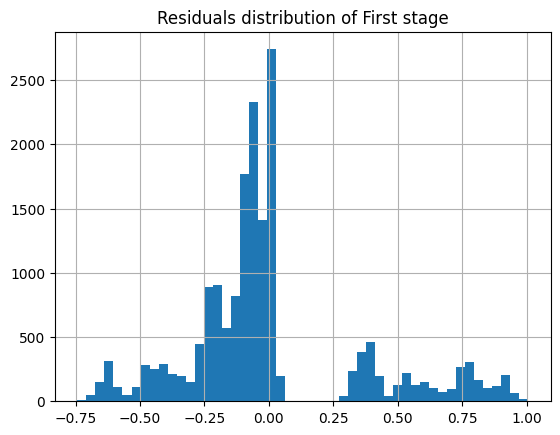

In [14]:
df_main['remote_hat'] = first_stage.predict()
df_main['resid'] = df_main['remote'] - df_main['remote_hat']

df_main['resid'].hist(bins=50)
plt.title("Residuals distribution of First stage")
plt.show()

<Axes: xlabel='remote_hat', ylabel='share_home'>

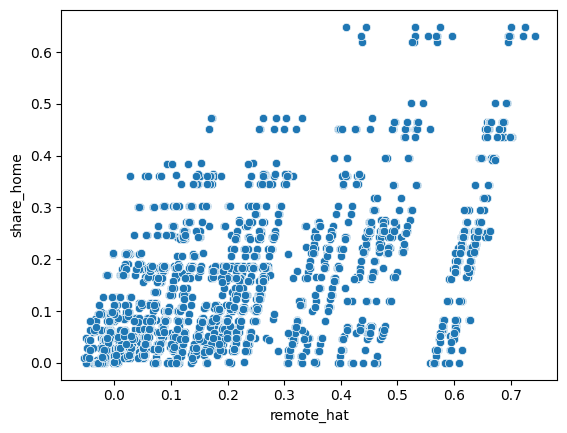

In [15]:
sns.scatterplot(x='remote_hat', y='share_home', data = df_main)

### Second stage

In [16]:

second_stage  =  smf.ols(
    """SALMEE_Y ~ 
    remote_hat + AGE + SEXE + NBENFLOG +
    APCS1_1  + APCS1_3 + APCS1_4 + APCS1_5 + APCS1_6 +
    has_child + 
    EDU_1 + EDU_2 + EDU_3 + EDU_4 + EDU_5 + EDU_6 + EDU_7 + EDU_8
    """
    , data=df_main).fit()
second_stage.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               SALMEE_Y   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     546.7
Date:                Fri, 16 May 2025   Prob (F-statistic):               0.00
Time:                        18:49:06   Log-Likelihood:            -1.4817e+05
No. Observations:               17740   AIC:                         2.964e+05
Df Residuals:                   17721   BIC:                         2.965e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1142.1380    235.289      4.854      0.000     680.948    1603.328
SEXE[T.2]   -355.8060     19.594    -18.159      0.000    -394.212    -317.400
remote_hat -1413.4434    357.096     -3.958      0.000   -2113.386    -713.501
AGE           19.9229      0.642     31.053      0.000      18.665      21.180
NBENFLOG      38.9736     10.489      3.716      0.000      18.414      59.533
APCS1_1    -1739.9932    555.285     -3.134      0.002   -2828.406    -651.580
APCS1_3     1038.8453    232.462      4.469      0.000     583.197    1494.494
APCS1_4     -290.0655    210.436     -1.378      0.168    -702.541     122.410
APCS1_5     -762.9329    210.752     -3.620      0.000   -1176.028    -349.838
APCS1_6     -732.1164    212.386     -3.447      0.001   -1148.415    -315.818
has_child     72.8209     25.125      2.898      0.004      23.572     122.069
EDU_1       -178.7666    114.895     -1.556      0.120    -403.971      46.438
EDU_2        260.8163    102.146      2.553      0.011      60.601     461.032
EDU_3        508.3986    100.397      5.064      0.000     311.610     705.187
EDU_4        522.2770    212.937      2.453      0.014     104.900     939.654
EDU_5        878.2974    117.949      7.446      0.000     647.106    1109.489
EDU_6        921.2101    112.073      8.220      0.000     701.536    1140.884
EDU_7       1511.1516    148.431     10.181      0.000    1220.212    1802.092
EDU_8       1196.0090    168.663      7.091      0.000     865.412    1526.606
==============================================================================
Omnibus:                    12566.917   Durbin-Watson:                   1.765
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           512135.098
Skew:                           2.926   Prob(JB):                         0.00
Kurtosis:                      28.663   Cond. No.                     3.48e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Second set of controls

### First stage regression

In [17]:
first_stage = ols(
    """
    remote ~ share_home + AGE + SEXE + NBENFLOG +
    has_child + 
    APCS1_1  + APCS1_3 + APCS1_4 + APCS1_5 + APCS1_6 +
    SEC_BE + SEC_FZ + SEC_GI + SEC_JZ + SEC_KZ + SEC_LZ + SEC_MN + SEC_OQ + SEC_RU  + 
    EDU_1 + EDU_2 + EDU_3 + EDU_4 + EDU_5 + EDU_6 + EDU_7 + EDU_8  
"""
, data = df_main).fit()
first_stage.summary()

    #     SEC_BE + SEC_FZ + SEC_GI + SEC_JZ + SEC_KZ + SEC_LZ + SEC_MN + SEC_OQ + SEC_RU  + 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 remote   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     307.1
Date:                Fri, 16 May 2025   Prob (F-statistic):               0.00
Time:                        18:49:06   Log-Likelihood:                -5381.8
No. Observations:               17740   AIC:                         1.082e+04
Df Residuals:                   17712   BIC:                         1.104e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0532      0.078     -0.679      0.497      -0.207       0.100
SEXE[T.2]      0.0403      0.006      7.097      0.000       0.029       0.051
share_home     0.1764      0.025      7.161      0.000       0.128       0.225
AGE            0.0008      0.000      3.677      0.000       0.000       0.001
NBENFLOG      -0.0033      0.003     -0.979      0.327      -0.010       0.003
has_child      0.0066      0.008      0.827      0.408      -0.009       0.022
APCS1_1       -0.0003      0.179     -0.002      0.999      -0.350       0.350
APCS1_3        0.2043      0.067      3.028      0.002       0.072       0.337
APCS1_4        0.0311      0.067      0.462      0.644      -0.101       0.163
APCS1_5       -0.0221      0.067     -0.327      0.744      -0.154       0.110
APCS1_6       -0.0805      0.067     -1.194      0.233      -0.213       0.052
SEC_BE         0.0681      0.022      3.121      0.002       0.025       0.111
SEC_FZ         0.0714      0.024      3.034      0.002       0.025       0.118
SEC_GI         0.0322      0.022      1.494      0.135      -0.010       0.074
SEC_JZ         0.3893      0.026     15.267      0.000       0.339       0.439
SEC_KZ         0.3786      0.025     14.903      0.000       0.329       0.428
SEC_LZ         0.0793      0.033      2.414      0.016       0.015       0.144
SEC_MN         0.1257      0.022      5.713      0.000       0.083       0.169
SEC_OQ        -0.0160      0.021     -0.744      0.457      -0.058       0.026
SEC_RU         0.0466      0.024      1.962      0.050    4.62e-05       0.093
EDU_1         -0.0081      0.037     -0.221      0.825      -0.080       0.064
EDU_2          0.0183      0.033      0.561      0.575      -0.046       0.082
EDU_3          0.0255      0.032      0.797      0.425      -0.037       0.088
EDU_4          0.1520      0.066      2.295      0.022       0.022       0.282
EDU_5          0.1420      0.033      4.368      0.000       0.078       0.206
EDU_6          0.1129      0.033      3.445      0.001       0.049       0.177
EDU_7          0.2625      0.033      7.916      0.000       0.197       0.327
EDU_8          0.3152      0.039      8.074      0.000       0.239       0.392
==============================================================================
Omnibus:                     2549.262   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4030.502
Skew:                           1.003   Prob(JB):                         0.00
Kurtosis:                       4.194   Cond. No.                     3.51e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.51e+03. This might indi

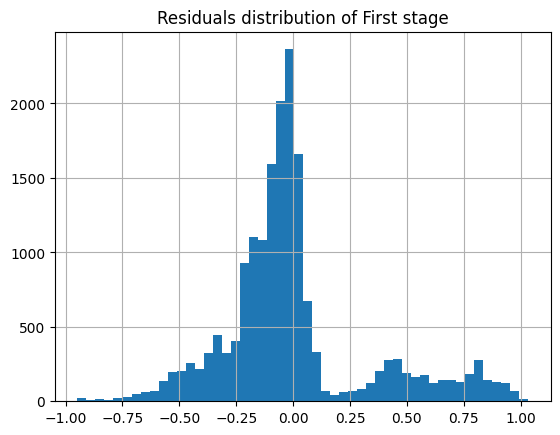

In [18]:
df_main['remote_hat'] = first_stage.predict()
df_main['resid'] = df_main['remote'] - df_main['remote_hat']

df_main['resid'].hist(bins=50)
plt.title("Residuals distribution of First stage")
plt.show()

<Axes: xlabel='remote_hat', ylabel='share_home'>

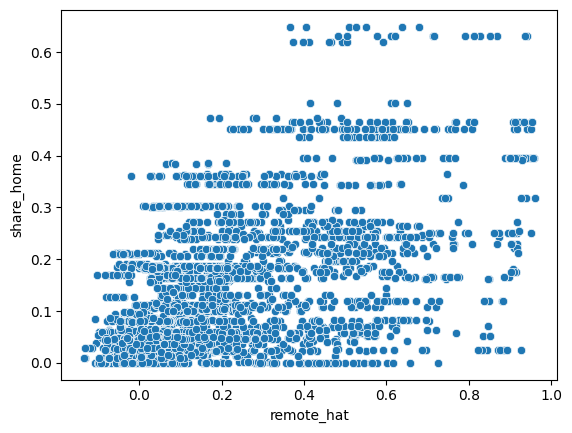

In [19]:
sns.scatterplot(x='remote_hat', y='share_home', data = df_main)

### Second stage

In [20]:

second_stage  =  smf.ols(
    """SALMEE_Y ~ 
    remote_hat + AGE + SEXE + NBENFLOG +
    APCS1_1  + APCS1_3 + APCS1_4 + APCS1_5 + APCS1_6 +
    has_child + 
    SEC_BE + SEC_FZ + SEC_GI + SEC_JZ + SEC_KZ + SEC_LZ + SEC_MN + SEC_OQ + SEC_RU  + 
    EDU_1 + EDU_2 + EDU_3 + EDU_4 + EDU_5 + EDU_6 + EDU_7 + EDU_8
    """
    , data=df_main).fit()
second_stage.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               SALMEE_Y   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     394.0
Date:                Fri, 16 May 2025   Prob (F-statistic):               0.00
Time:                        18:49:07   Log-Likelihood:            -1.4791e+05
No. Observations:               17740   AIC:                         2.959e+05
Df Residuals:                   17712   BIC:                         2.961e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    740.3907    240.904      3.073      0.002     268.196    1212.585
SEXE[T.2]   -310.5015     24.766    -12.537      0.000    -359.045    -261.958
remote_hat  -483.3223    430.842     -1.122      0.262   -1327.814     361.169
AGE           20.6996      0.725     28.567      0.000      19.279      22.120
NBENFLOG      35.2470     10.399      3.389      0.001      14.863      55.631
APCS1_1    -1262.3763    551.138     -2.290      0.022   -2342.660    -182.092
APCS1_3      766.5134    225.488      3.399      0.001     324.536    1208.491
APCS1_4     -272.4784    207.737     -1.312      0.190    -679.663     134.706
APCS1_5     -659.8141    208.761     -3.161      0.002   -1069.006    -250.622
APCS1_6     -672.1180    212.939     -3.156      0.002   -1089.499    -254.737
has_child     62.8127     24.972      2.515      0.012      13.865     111.760
SEC_BE       622.1195     70.909      8.773      0.000     483.130     761.109
SEC_FZ       501.3315     76.298      6.571      0.000     351.780     650.883
SEC_GI       316.9899     66.539      4.764      0.000     186.567     447.413
SEC_JZ       444.1154    185.683      2.392      0.017      80.158     808.072
SEC_KZ       822.8959    177.527      4.635      0.000     474.926    1170.866
SEC_LZ       590.0414    104.320      5.656      0.000     385.564     794.519
SEC_MN       273.0587     83.335      3.277      0.001     109.715     436.403
SEC_OQ       179.9844     67.039      2.685      0.007      48.581     311.388
SEC_RU      -122.2248     75.497     -1.619      0.105    -270.205      25.756
EDU_1       -186.3988    113.452     -1.643      0.100    -408.776      35.978
EDU_2        219.6538    100.850      2.178      0.029      21.978     417.330
EDU_3        436.7853     99.332      4.397      0.000     242.084     631.487
EDU_4        459.4464    214.380      2.143      0.032      39.241     879.652
EDU_5        670.6137    119.260      5.623      0.000     436.853     904.375
EDU_6        782.5718    113.728      6.881      0.000     559.654    1005.490
EDU_7       1201.1884    155.432      7.728      0.000     896.527    1505.850
EDU_8        957.4427    186.659      5.129      0.000     591.573    1323.313
==============================================================================
Omnibus:                    12845.481   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           550186.862
Skew:                           3.010   Prob(JB):                         0.00
Kurtosis:                      29.610   Cond. No.                     3.51e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.51e+03. This might indi

# Sector analysis

In [22]:
sector_cols = [col for col in df_main.columns if col.startswith('SEC_')]
telework_by_sector = {}
for sector in sector_cols:
    telework_avg = round(df_main.loc[df_main[sector]==1, 'remote'].mean(),3)
    telework_nb = df_main.loc[df_main[sector]==1, 'remote'].sum()
    women_nb = len(df_main.loc[(df_main[sector]==1)&(df_main['SEXE']=='2')])
    women_share = round(women_nb / len(df_main.loc[(df_main[sector]==1)]),3)
    nb = len(df_main.loc[df_main[sector]==1])
    telework_by_sector[sector] = {
                                  'count' : nb, 
                                  'avg_telework' : telework_avg, 
                                  'number_teleworker': telework_nb,
                                  'women_nb':women_nb,
                                  'women_share':women_share
                                  
                                  }


telework_by_sector = pd.DataFrame.from_dict(telework_by_sector, orient='index')
telework_by_sector.sort_values(by='avg_telework', ascending=False)

,count,avg_telework,number_teleworker,women_nb,women_share
SEC_JZ,552,0.768,424,208,0.377
SEC_KZ,556,0.676,376,336,0.604
SEC_MN,2132,0.283,604,1000,0.469
SEC_LZ,172,0.256,44,84,0.488
SEC_RU,888,0.212,188,576,0.649
SEC_00,20,0.200,4,12,0.600
SEC_BE,2436,0.174,424,636,0.261
SEC_OQ,6020,0.151,908,4352,0.723
SEC_GI,3848,0.109,420,1656,0.430
SEC_FZ,876,0.096,84,136,0.155


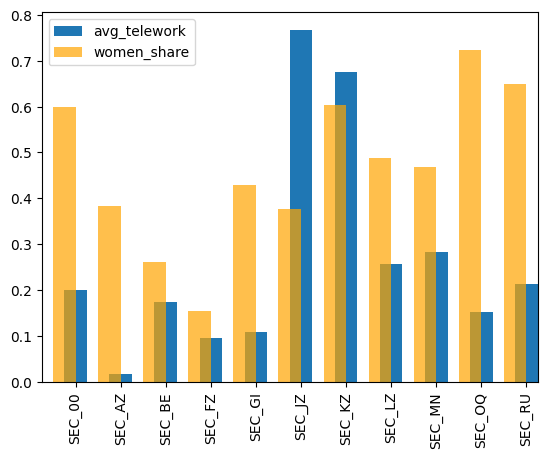

In [23]:
ax = telework_by_sector[['avg_telework']].plot(kind='bar', label='mean number of teleworkers')
telework_by_sector[['women_share']].plot(kind='bar', ax =ax, position=1, color='orange', alpha=0.7, label='Women share')
plt.legend()
plt.show()

# Other

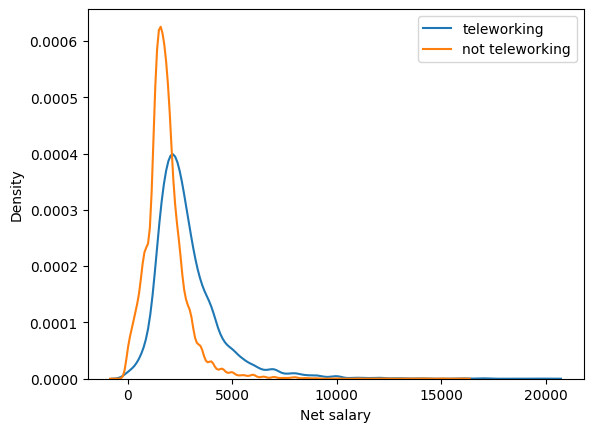

In [28]:
sns.kdeplot(df_remote['SALMEE_Y'], label='teleworking')
sns.kdeplot(df_no_remote['SALMEE_Y'], label='not teleworking')
plt.legend()
plt.xlabel('Net salary')
plt.show()